# Hluttaw Statistics

In [22]:
import datetime
from dateutil import parser
import requests
import json
import pandas

import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

In [23]:
def age(str):
    #calculate age based on date strings stored in Popit
    born = parser.parse(str)
    today = datetime.date.today()
    age = today.year - born.year - ((today.month, today.day) < (born.month, born.day)) 
    return int(age)

In [24]:
#Getting total number of pages via REST request
page_request = requests.get('http://api.openhluttaw.org/en/persons')
pages = page_request.json()['num_pages']

#Fetch and build list of all representatives
persons =[]
for page in range(1,pages+1):
    req_representatives = requests.get('http://api.openhluttaw.org/en/persons?page='+str(page))
    for person in json.loads(req_representatives.content)['results']:
        persons.append(person)
        
for person in persons:
    if person['birth_date']:
        person['age'] = age(person['birth_date'])

## Age Stats

In [25]:
import pandas
data = { "age": [], "birth_date":[] }
data_index = { "age": [], "birth_date":[]}

for entry in persons:
    if entry.has_key('age'):
        data["age"].append(entry["age"])
        data_index["age"].append(entry["name"])
        data["birth_date"].append(entry["birth_date"])
        data_index["birth_date"].append(entry["name"])
        

final_data = { "age": pandas.Series(data["age"], index=data_index["age"]),
                "birth_date": pandas.Series(data["birth_date"], index=data_index["birth_date"])
             }
persons_age_df = pandas.DataFrame(final_data)
persons_age_df.sort_values(by="age")

print "Median:" + " " + str(persons_age_df['age'].median())
print "Youngest:" + " " + str(persons_age_df['age'].min())
print "Oldest:" + " " + str(persons_age_df['age'].max())

Median: 55.0
Youngest: 27
Oldest: 81


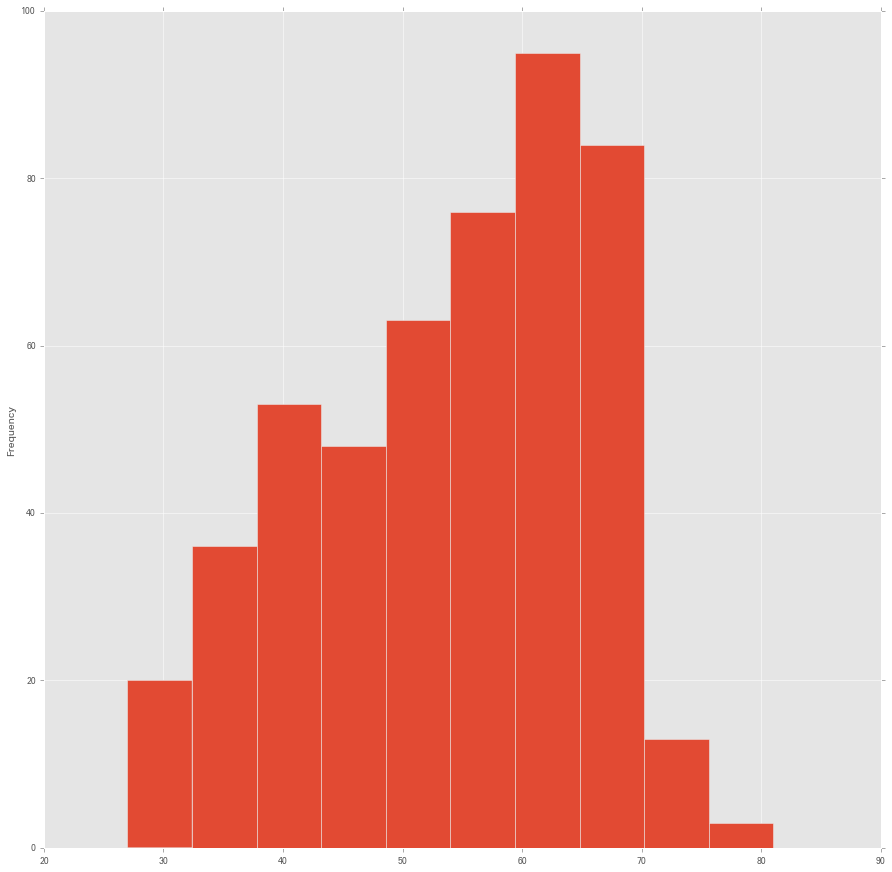

In [26]:
persons_age_df["age"].plot(kind="hist",figsize=(15,15))

# Gender

In [27]:
women_reps = []
for person in persons:
    if person['gender'] == 'female':
        women_reps.append(person)

print "Number of Women reps " + str(len(women_reps))     

print "Percentage of Women representatives " + "{0:.2f}".format(65/498.0*100)+"%"

Number of Women reps 65
Percentage of Women representatives 13.05%


#Ethnicity National Identity

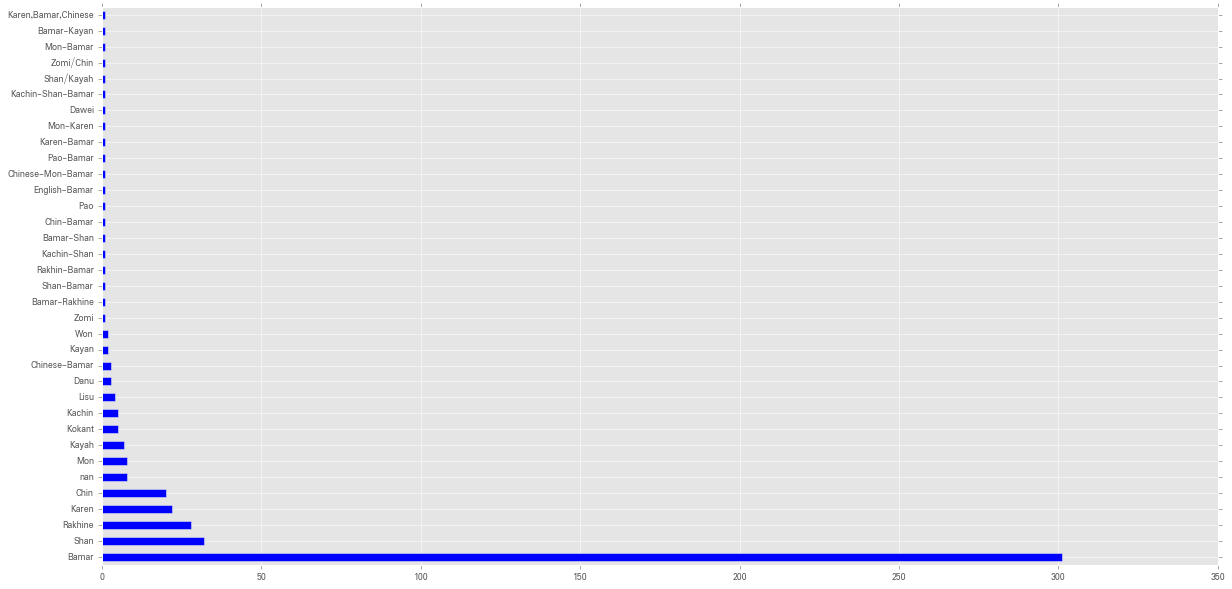

In [28]:
#data is a bit mixed with some unicode myanmar language, not count these for now

def is_ascii(s):
    return all(ord(c) < 128 for c in s)


data = { "name": [], "national_identity":[] }

for entry in persons:
    if entry['national_identity']:
        if is_ascii(entry['national_identity']):
            data["national_identity"].append(entry["national_identity"])
            data["name"].append(entry["name"])
        
        
national_identity_df = pandas.DataFrame(data)

series = (national_identity_df['national_identity'])

bar = series.value_counts()
bar.plot.barh(figsize=(20,10))

#Amyotha Stats

In [29]:
amyotha_req = requests.get('http://api.openhluttaw.org/en/organizations/897739b2831e41109713ac9d8a96c845')

In [30]:
memberships = json.loads(amyotha_req.content)['result']['memberships']

In [31]:
amyotha = []
for member in memberships:
    r = requests.get('http://api.openhluttaw.org/en/organizations/' + member['on_behalf_of_id'])
    if json.loads(r.content)['result']['name']:
        party = json.loads(r.content)['result']['name']
        amyotha.append({'consituency': member['post']['label'],
                    'party':party , 'gender':member['person']['gender'].lower() })

## Gender Ratio by Party

In [32]:
amyotha_df = pandas.DataFrame(amyotha)


amyotha_df_gender=amyotha_df.drop('consituency',axis=1)

gender_counts = amyotha_df_gender.groupby('party')['gender'].value_counts()
gender_counts

party                                          gender
Arakan National Party                          male        9
                                               female      1
Independent                                    male        2
Mon National Party                             male        1
National League for Democracy                  male      116
                                               female     20
National Unity Party                           male        1
Pao National Organization                      male        1
Shan Nationalities League for Democracy Party  male        3
The Taaung (Palaung) National Party            male        2
Union Solidarity and Development Party         male       10
                                               female      1
Zomi Congress for Democracy                    female      1
                                               male        1
dtype: int64

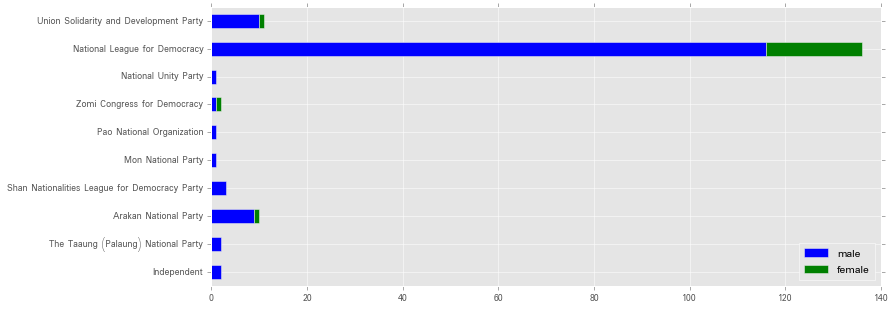

In [33]:
#this is horrible, but it's 2:30am probably can be done better with pandas functions - Khairil
#better example contribution welcome

matplotlib.style.use('ggplot')

index_party = []
gender_values = []

for party in gender_counts.index:
    index_party.append(party[0])

index_party = list(set(index_party))

for party in index_party:
    male_count = gender_counts[party].male
    if 'female' in gender_counts[party].index:
        female_count = gender_counts[party].female
    else:
        female_count=0
    
    gender_values.append([male_count,female_count])
    
gender_df = pandas.DataFrame(gender_values, index=index_party, columns=['male','female'])
    
gender_df.plot.barh(stacked=True,figsize=(12,5))

## Breakdown by Party

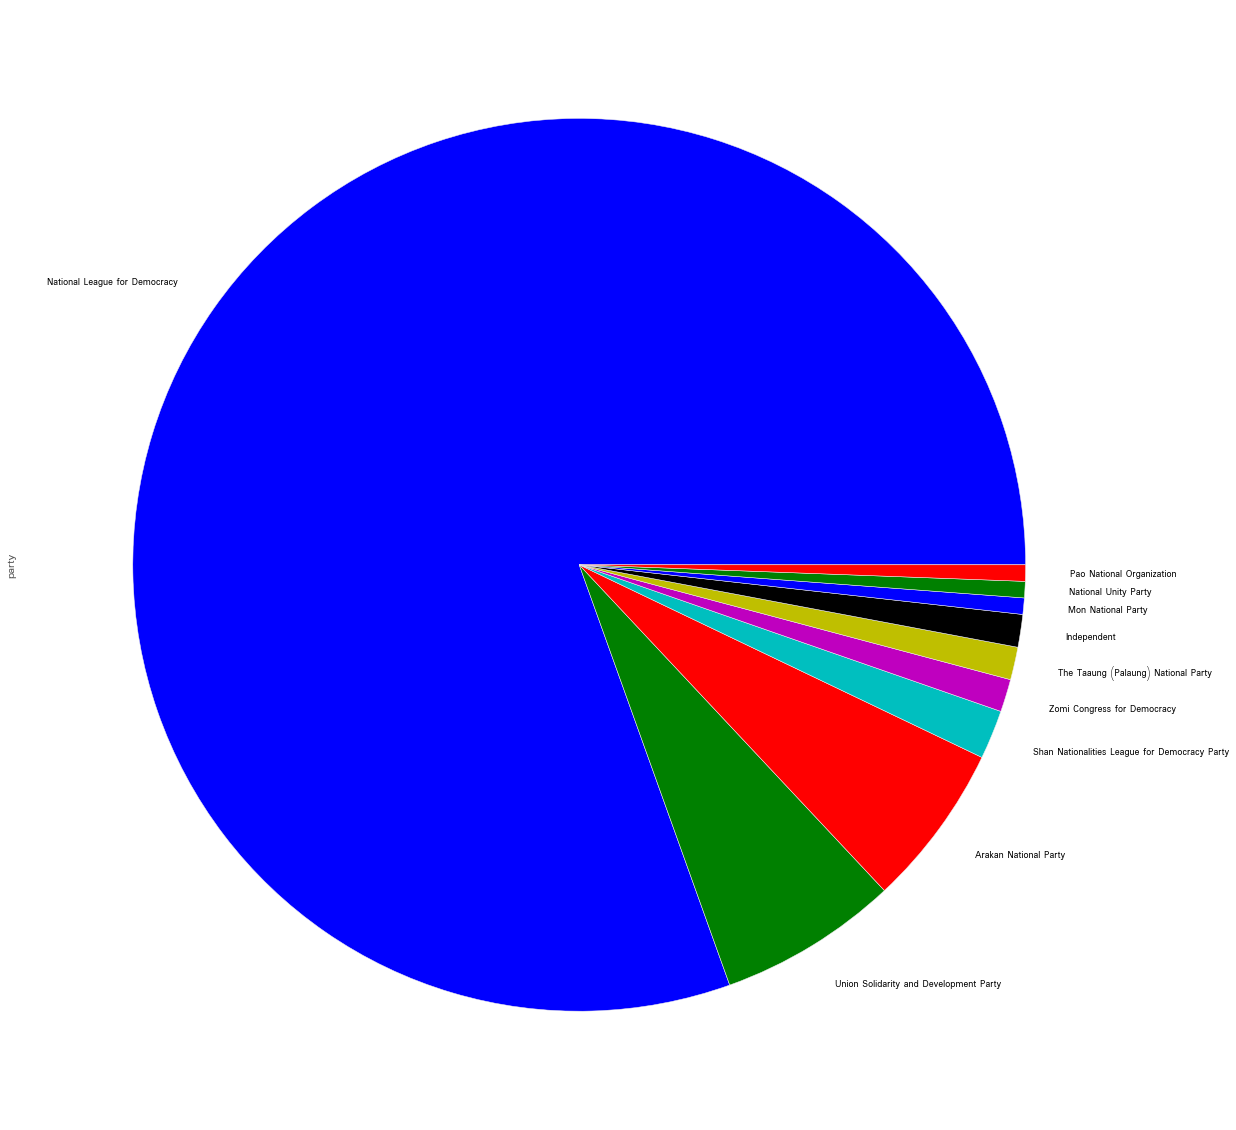

In [34]:
parties = amyotha_df['party']
pie = parties.value_counts()
pie.plot.pie(figsize=(20,20))

## Gender breakdown by party Myanmar language encoding

In [35]:
amyotha_req = requests.get('http://api.openhluttaw.org/my/organizations/897739b2831e41109713ac9d8a96c845')

memberships = json.loads(amyotha_req.content)['result']['memberships']

amyotha_my = []
for member in memberships:
    r = requests.get('http://api.openhluttaw.org/my/organizations/' + member['on_behalf_of_id'])
    if json.loads(r.content)['result']['name']:
        party = json.loads(r.content)['result']['name']
        amyotha_my.append({'consituency': member['post']['label'],
                    'party':party , 'gender':member['person']['gender'].lower() })
        
amyotha_my_df = pandas.DataFrame(amyotha_my)
amyotha_df_gender=amyotha_my_df.drop('consituency',axis=1)

gender_counts = amyotha_df_gender.groupby('party')['gender'].value_counts()
gender_counts

party                                         gender
တသီးပုဂ္ဂလ                                    male        2
တိုင်းရင်းသားစည်းလုံးညီညွတ်ရေးပါတီ            male        1
ပအိုဝ်းအမျိုးသားအဖွဲ့ချုပ်(PNO)ပါတီ           male        1
ပြည်ထောင်စုကြံ့ခိုင်ရေးနှင့်ဖွံ့ဖြိုးရေးပါတီ  male       10
                                              female      1
မွန်အမျိုးသားပါတီ                             male        1
အမျိုးသားဒီမိုကရေစီအဖွဲ့ချုပ်ပါတီ             male      116
                                              female     20
dtype: int64

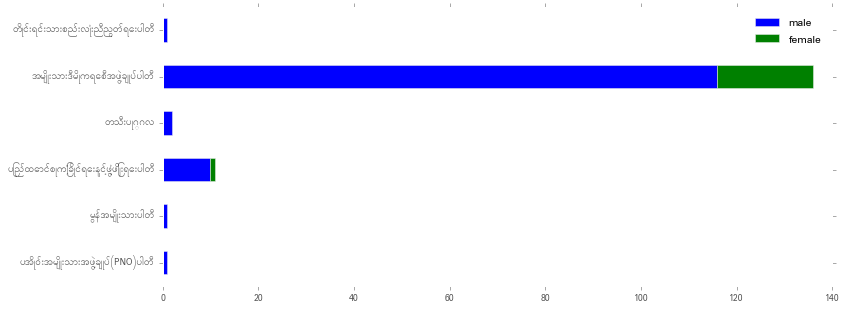

In [36]:
#this is horrible, but it's 2:30am probably can be done better with pandas functions - Khairil
#better example contribution welcome

index_party = []
gender_values = []

for party in gender_counts.index:
    index_party.append(party[0])

index_party = list(set(index_party))

for party in index_party:
    male_count = gender_counts[party].male
    if 'female' in gender_counts[party].index:
        female_count = gender_counts[party].female
    else:
        female_count=0
    
    gender_values.append([male_count,female_count])
    
gender_df = pandas.DataFrame(gender_values, index=index_party, columns=['male','female'])

import matplotlib
%matplotlib inline
matplotlib.rc('font', family='Padauk') #Needed for proper rendering of characters
gender_df.plot.barh(stacked=True,figsize=(12,5))

# Pyithu Stats

## Party Breakdown


In [37]:
pyithu_req = requests.get('http://api.openhluttaw.org/en/organizations/7f162ebef80e4a4aba12361ea1151fce')
memberships = pyithu_req.json()['result']['memberships']

pyithu = []

for member in memberships:
    r = requests.get('http://api.openhluttaw.org/en/organizations/' + member['on_behalf_of_id'])
    if json.loads(r.content)['result']['name']:
        party = json.loads(r.content)['result']['name']
        pyithu.append({'consituency': member['post']['label'],
                    'party':party })

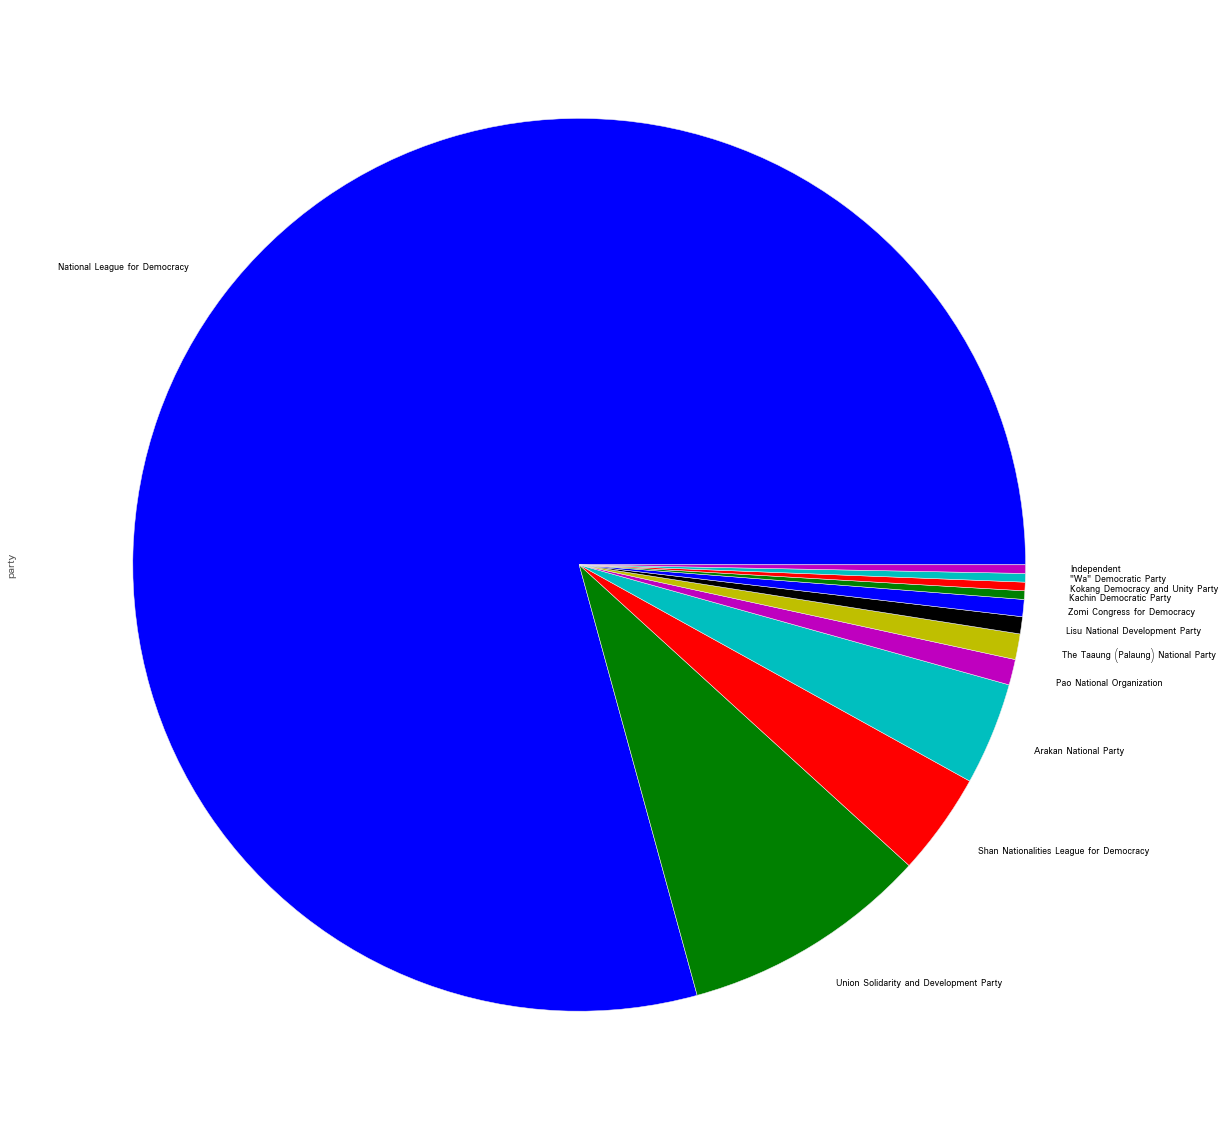

In [38]:
%matplotlib inline 
pyithu_df = pandas.DataFrame(pyithu)
parties = pyithu_df['party']
pie = parties.value_counts()
pie.plot.pie(figsize=(20,20))